In [1]:
#https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
#https://archive.ics.uci.edu/dataset/109/wine

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
# import breast cancer & wine datasets
breast_cancer = fetch_ucirepo(id=17)
wine = fetch_ucirepo(id=109)

print(breast_cancer.variables)
print(wine.variables)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

In [8]:
random_shuffle_state = 2024

In [9]:
scaler = StandardScaler()

In [10]:
def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [11]:
wine.data.targets['class'] = wine.data.targets['class'] - 1
wine_X_train, wine_y_train, wine_X_valid, wine_y_valid, wine_X_test, wine_y_test = train_valid_test_split(wine.data.features, wine.data.targets)

<ipython-input-11-b48e8fa4a2fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1


In [12]:
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
breast_X_train, breast_y_train, breast_X_valid, breast_y_valid, breast_X_test, breast_y_test = train_valid_test_split(breast_cancer.data.features, breast_cancer.data.targets)

<ipython-input-12-9c176ede9c04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'


In [13]:
wine_X_train = scaler.fit_transform(wine_X_train)
wine_X_valid = scaler.fit_transform(wine_X_valid)
wine_X_test = scaler.fit_transform(wine_X_test)

wine_X_train = torch.tensor(wine_X_train, dtype=torch.float32)
wine_X_valid = torch.tensor(wine_X_valid, dtype=torch.float32)
wine_X_test = torch.tensor(wine_X_test, dtype=torch.float32)

wine_y_train = torch.tensor(wine_y_train.values, dtype=torch.long).flatten()
wine_y_valid = torch.tensor(wine_y_valid.values, dtype=torch.long).flatten()
wine_y_test = torch.tensor(wine_y_test.values, dtype=torch.long).flatten()

In [14]:
breast_X_train = scaler.fit_transform(breast_X_train)
breast_X_valid = scaler.fit_transform(breast_X_valid)
breast_X_test = scaler.fit_transform(breast_X_test)

breast_X_train = torch.tensor(breast_X_train, dtype=torch.float32)
breast_X_valid = torch.tensor(breast_X_valid, dtype=torch.float32)
breast_X_test = torch.tensor(breast_X_test, dtype=torch.float32)

breast_y_train = torch.tensor(breast_y_train.values, dtype=torch.long).flatten()
breast_y_valid = torch.tensor(breast_y_valid.values, dtype=torch.long).flatten()
breast_y_test = torch.tensor(breast_y_test.values, dtype=torch.long).flatten()

In [15]:
class WineNN(nn.Module):
  def __init__(self, num_features, hidden_size, output_size):
    super(WineNN, self).__init__()
    self.layer1 = nn.Linear(num_features, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.out(x)
    return self.softmax(x)

In [16]:
wine_num_features = wine_X_train.shape[1]

In [17]:
model = WineNN(wine_num_features, 64, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [18]:
class BreastCancerNN(nn.Module):
  def __init__(self, num_features, hidden_size, output_size):
    super(BreastCancerNN, self).__init__()
    self.layer1 = nn.Linear(num_features, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.out(x)
    return self.softmax(x)

In [19]:
breast_cancer_num_features = breast_X_train.shape[1]

In [20]:
def train(X_train, y_train, X_valid, y_valid, model, criterion, optimizer, dataset_name):
  loss_values = []
  val_loss_values = []
  len_x_train = len(X_train)
  len_y_valid = len(y_valid)
  for epoch in range(10):
      running_loss = 0.0
      for i, data in enumerate(X_train, 0):
          inputs = data
          labels = y_train[i]
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % len_x_train == len_x_train - 1:
              print(f"[{epoch + 1}, {i + 1}] train loss: {running_loss / len_x_train:.3f}")
              loss_values.append(running_loss / len_x_train)
              running_loss = 0.0
      model.eval()
      val_loss = 0.0
      correct = 0
      with torch.no_grad():
          for i, data in enumerate(X_valid, 0):
              inputs = data
              labels = y_valid[i]
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs, 0)
              correct += (predicted == labels).sum().item()
              if i % len_y_valid == len_y_valid - 1:
                print(f"[{epoch + 1}, {i + 1}] validation loss: {val_loss / len_y_valid:.3f}")
                val_loss_values.append(val_loss / len_y_valid)
                val_loss = 0.0
  plt.plot(loss_values)
  plt.title(f"{dataset_name} dataset - training loss")
  plt.show()
  plt.plot(val_loss_values)
  plt.title(f"{dataset_name} dataset - validation loss")
  plt.show()

In [21]:
def test(X_test, y_test, model, criterion, optimizer, dataset_name):
  correct = 0
  predictions = []
  with torch.no_grad():
      for i, data in enumerate(X_test, 0):
          inputs = data
          labels = y_test[i]
          outputs = model(inputs)
          predicted = outputs.cpu().numpy().argmax(axis=0)
          predictions.append(predicted)
          correct += (predicted == labels).sum().item()

  print(f"Accuracy on the test set: {100 * correct / len(y_test):.2f}%")
  return predictions

In [22]:
def present_metrics(predictions, y_test, targets):
  # Accuracy
  y_true = y_test.cpu().numpy()
  y_pred = np.array(predictions)
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)

  # Precision
  precision = precision_score(y_true, y_pred, average='weighted')
  print("Precision:", precision)

  # Recall
  recall = recall_score(y_true, y_pred, average='weighted')
  print("Recall:", recall)

  # F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')
  print("F1 Score:", f1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                            display_labels=np.unique(targets))
  disp.plot()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1, 106] train loss: 0.917
[1, 17] validation loss: 0.652
[2, 106] train loss: 0.612
[2, 17] validation loss: 0.574
[3, 106] train loss: 0.588
[3, 17] validation loss: 0.570
[4, 106] train loss: 0.568
[4, 17] validation loss: 0.570
[5, 106] train loss: 0.566
[5, 17] validation loss: 0.565
[6, 106] train loss: 0.567
[6, 17] validation loss: 0.558
[7, 106] train loss: 0.561
[7, 17] validation loss: 0.558
[8, 106] train loss: 0.568
[8, 17] validation loss: 0.556
[9, 106] train loss: 0.554
[9, 17] validation loss: 0.560
[10, 106] train loss: 0.554
[10, 17] validation loss: 0.557


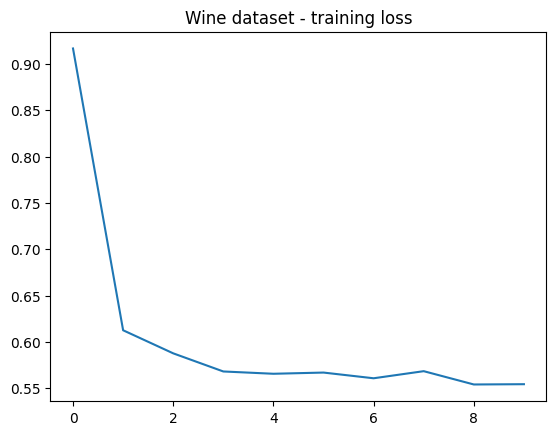

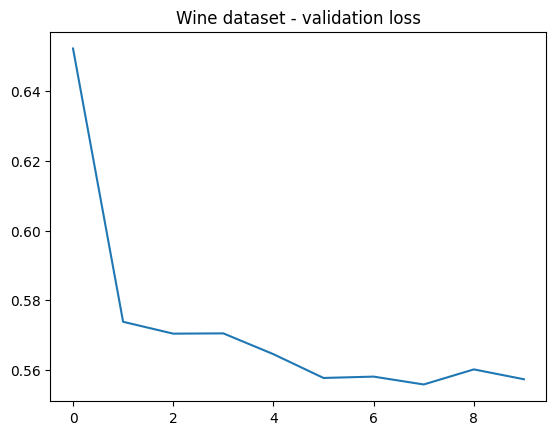

Accuracy on the test set: 94.55%
Accuracy: 0.9454545454545454
Precision: 0.9545454545454546
Recall: 0.9454545454545454
F1 Score: 0.9461157024793387


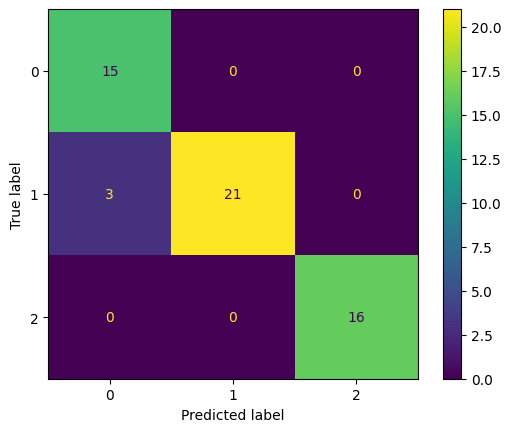

In [23]:
train(wine_X_train, wine_y_train, wine_X_valid, wine_y_valid, model, criterion, optimizer, 'Wine')
wine_predictions = test(wine_X_test, wine_y_test, model, criterion, optimizer, 'Wine')
present_metrics(wine_predictions, wine_y_test, wine.data.targets)

In [24]:
model = BreastCancerNN(breast_cancer_num_features, 32, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1, 341] train loss: 0.439
[1, 56] validation loss: 0.383
[2, 341] train loss: 0.343
[2, 56] validation loss: 0.376
[3, 341] train loss: 0.332
[3, 56] validation loss: 0.385
[4, 341] train loss: 0.327
[4, 56] validation loss: 0.379
[5, 341] train loss: 0.323
[5, 56] validation loss: 0.381
[6, 341] train loss: 0.321
[6, 56] validation loss: 0.383
[7, 341] train loss: 0.320
[7, 56] validation loss: 0.386
[8, 341] train loss: 0.320
[8, 56] validation loss: 0.387
[9, 341] train loss: 0.319
[9, 56] validation loss: 0.391
[10, 341] train loss: 0.319
[10, 56] validation loss: 0.403


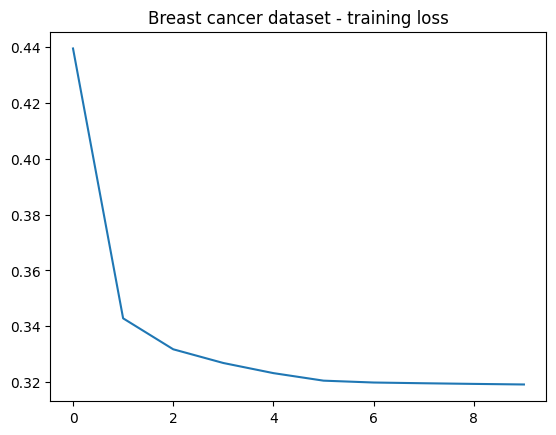

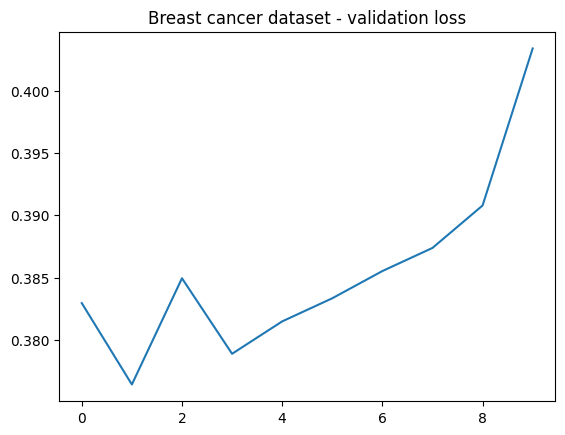

Accuracy on the test set: 95.35%
Accuracy: 0.9534883720930233
Precision: 0.9552338120475482
Recall: 0.9534883720930233
F1 Score: 0.9531332210880775


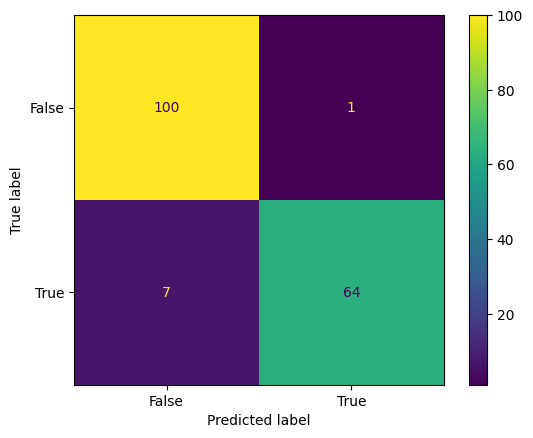

In [25]:
train(breast_X_train, breast_y_train, breast_X_valid, breast_y_valid, model, criterion, optimizer, 'Breast cancer')
breast_predictions = test(breast_X_test, breast_y_test, model, criterion, optimizer, 'Breast cancer')
present_metrics(breast_predictions, breast_y_test, breast_cancer.data.targets)

In [93]:
# import internet firewall data
internet_firewall = pd.read_csv('./log2.csv')

print(internet_firewall.head(5))

   Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2 

In [116]:
internet_firewall_features = internet_firewall[filter(lambda x: x != 'Action', internet_firewall.columns)]
internet_firewall_num_features = len(internet_firewall_features.columns)

internet_firewall_targets = internet_firewall['Action']

In [117]:
le = LabelEncoder()

internet_firewall_targets = le.fit_transform(internet_firewall_targets)

internet_firewall_classes_num = len(np.unique(internet_firewall_targets))

In [118]:
internet_X_train, internet_y_train, internet_X_valid, internet_y_valid, internet_X_test, internet_y_test = train_valid_test_split(internet_firewall_features, internet_firewall_targets, test_p = 0.2)

In [119]:
internet_X_train = scaler.fit_transform(internet_X_train)
internet_X_valid = scaler.fit_transform(internet_X_valid)
internet_X_test = scaler.fit_transform(internet_X_test)

internet_X_train = torch.tensor(internet_X_train, dtype=torch.float32)
internet_X_valid = torch.tensor(internet_X_valid, dtype=torch.float32)
internet_X_test = torch.tensor(internet_X_test, dtype=torch.float32)

internet_y_train = torch.tensor(internet_y_train, dtype=torch.long).flatten()
internet_y_valid = torch.tensor(internet_y_valid, dtype=torch.long).flatten()
internet_y_test = torch.tensor(internet_y_test, dtype=torch.long).flatten()

In [120]:
print(internet_X_train)

tensor([[-2.5011,  1.3935, -0.8777,  ..., -0.2157, -0.0123, -0.0267],
        [ 0.1648, -0.5482,  0.4771,  ..., -0.1010, -0.0110, -0.0250],
        [ 0.6830, -0.5482,  0.9129,  ..., -0.1207, -0.0061, -0.0136],
        ...,
        [ 0.2045, -0.5482,  0.8394,  ...,  0.5579,  0.0245,  0.0603],
        [ 0.1609, -0.5482,  1.3086,  ..., -0.1141, -0.0102, -0.0237],
        [ 0.3459, -0.5481, -0.8777,  ..., -0.2157, -0.0123, -0.0267]])


In [121]:
class InternetFirewallNN(nn.Module):
  def __init__(self, num_features, hidden_size, output_size):
    super(InternetFirewallNN, self).__init__()
    self.layer1 = nn.Linear(num_features, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size * 2)
    self.layer3 = nn.Linear(hidden_size * 2, hidden_size * 3)
    self.layer4 = nn.Linear(hidden_size * 3, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.dropout1(x)
    x = self.layer3(x)
    x = self.dropout2(x)
    x = self.layer4(x)
    x = self.relu(x)
    x = self.out(x)
    return self.softmax(x)

In [122]:
model = InternetFirewallNN(internet_firewall_num_features, 64, 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1, 45872] train loss: 0.787
[1, 6553] validation loss: 0.756
[2, 45872] train loss: 0.757
[2, 6553] validation loss: 0.756
[3, 45872] train loss: 0.757
[3, 6553] validation loss: 0.756
[4, 45872] train loss: 0.756
[4, 6553] validation loss: 0.759
[5, 45872] train loss: 0.757
[5, 6553] validation loss: 0.755
[6, 45872] train loss: 0.757
[6, 6553] validation loss: 0.757
[7, 45872] train loss: 0.757
[7, 6553] validation loss: 0.755
[8, 45872] train loss: 0.757
[8, 6553] validation loss: 0.755
[9, 45872] train loss: 0.756
[9, 6553] validation loss: 0.789
[10, 45872] train loss: 0.756
[10, 6553] validation loss: 0.755


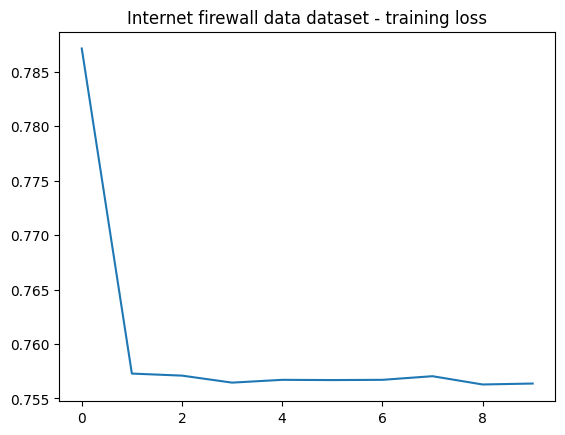

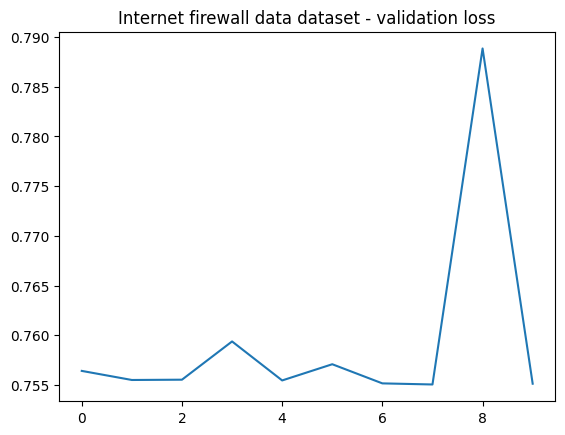

Accuracy on the test set: 99.05%


In [123]:
train(internet_X_train, internet_y_train, internet_X_valid, internet_y_valid, model, criterion, optimizer, 'Internet firewall data')
internet_predictions = test(internet_X_test, internet_y_test, model, criterion, optimizer, 'Internet firewall data')

Accuracy: 0.9905394064240483
Precision: 0.9899823855687762
Recall: 0.9905394064240483
F1 Score: 0.9902114844374124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


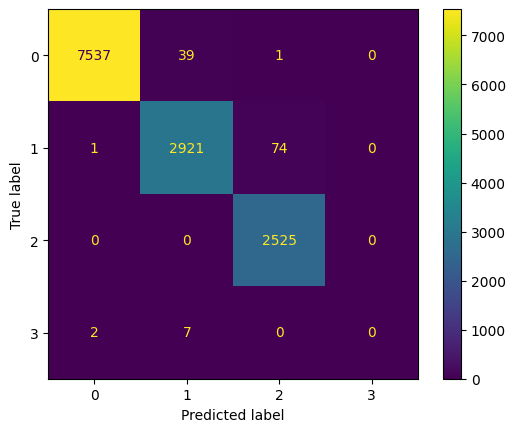

In [124]:
present_metrics(internet_predictions, internet_y_test, internet_firewall_targets)